# Art Generating AI using GAN

In [1]:
#Importing Libraries
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

For this project, I am using .jpg files of images of portraits. The dataset includes various artists. I am loading data as TensorFlow.Dataset,, with a batch size of 64. I have reduced the image size to (64,64), presuming, it will be computationally less taxing on the CPU.

In [2]:
#Importing data
data_path = "images"
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 742 files belonging to 1 classes.


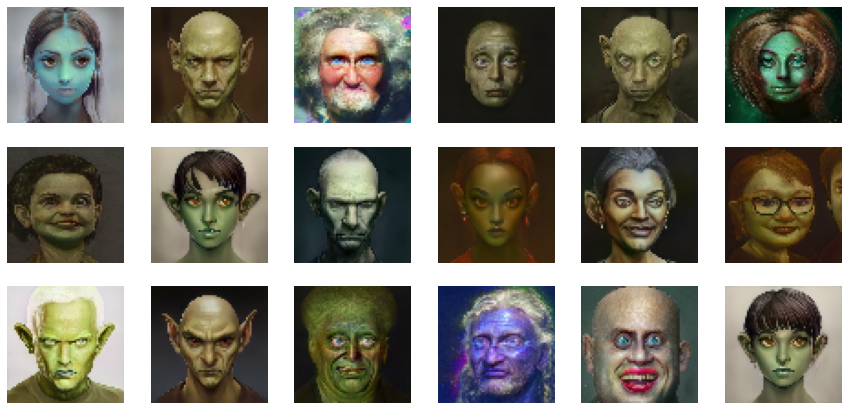

In [5]:
# Lets view the data
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset            
Show_Img(data)

Most of the images are portraits. A portrait is a painting representation of a person, The face is predominantly depicted portraits along with expressions and postures. To represent the personality of the subject. Since our model is relative a smaller GAN we have reduced the size of the image.

#### Preprocessing the data

Normalization: For the data normalization, I will convert the data in the range between 0 to 1. This helps in fast convergence and makes it easy for the computer to do calculations faster. Each of the three RGB channels in the image can take pixel values ranging from 0 to 255. Dividing it by 255 converts it to a range between 0 to 1. By doing this we

In [6]:
#Preprocessing the dataset for model
data = data.map(lambda x: x / 255.0)
data

<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

Now the data is up as a tensorflow Dataset object and is Prepocessed. Next up is building the GAN.

## Building GAN

GANs employs deep learning methods. It is a dexterous way of posing the problem as a supervised learning problem. It is composed of two models namely Generator and a Discriminator.

Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look like the dataset while a discriminator ("the art critic") learns to tell real images apart from fakes.

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.

### Building the generator

In [7]:
latent_dim = 100
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 256)         0

Now that the Generator is framed, let us see what random output our untrained Generator produces to get an idea of the process.

(-0.5, 63.5, 63.5, -0.5)

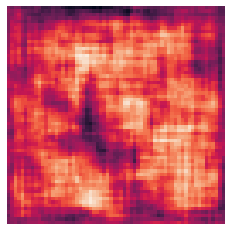

In [8]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training 
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

Clearly, the output is a random seed containing noise as the Generator is not trained yet.

### Building the discriminator

In [9]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

Now with this discriminator(untrained), let us see what verdict it has for the previously generated image with random noise.

In [10]:
#for the random image generated
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.499186]], shape=(1, 1), dtype=float32)


The output of the discriminator i.e. The Verdict, Says that there is almost a fifty-fifty chance of the image being real. This is so because the Discriminator is not yet trained. So basically, An untrained Generarator generated some pixel-noise and the untrained Discriminator classified it as "can't tell". So far we are on a right track.

Let us proceed and build the GAN architecture to train.

## GAN Compilation

GAN training has two sections:

Section 1: The Discriminator is trained while the Generator is idle. The discriminator is trained real images and random noise (from an untrained generator). This trains it to tell between fake and real. This accommodates the discriminator to predict as fakes.

Section 2: The Generator is trained while the Discriminator is idle. In this section, the generator is trained. After training the Discriminator, this step uses the predictions from the discriminator. Grants the generator to adjust the weights to try to deceive the discriminator.

The above method is repeated for a few epochs.

In [12]:
#Code Sourced from keras sample.

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## Training the Model

In [13]:
#Defining the number of epochs
epochs = 200
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

Epoch 1/200
12/12 [==============================] - 172s 14s/step - d_loss: 0.6790 - g_loss: 0.8029
Epoch 2/200
12/12 [==============================] - 178s 15s/step - d_loss: 0.6682 - g_loss: 0.6291
Epoch 3/200
12/12 [==============================] - 173s 14s/step - d_loss: 0.6012 - g_loss: 0.8696
Epoch 4/200
12/12 [==============================] - 181s 15s/step - d_loss: 0.6026 - g_loss: 0.7063
Epoch 5/200
12/12 [==============================] - 175s 14s/step - d_loss: 0.6113 - g_loss: 0.7271
Epoch 6/200
12/12 [==============================] - 172s 14s/step - d_loss: 0.6064 - g_loss: 0.8365
Epoch 7/200
12/12 [==============================] - 175s 15s/step - d_loss: 0.5974 - g_loss: 0.7554
Epoch 8/200
12/12 [==============================] - 175s 14s/step - d_loss: 0.6239 - g_loss: 0.7815
Epoch 9/200
12/12 [==============================] - 174s 14s/step - d_loss: 0.6226 - g_loss: 0.9279
Epoch 10/200
12/12 [==============================] - 173s 14s/step - d_loss: 0.7070 - g_lo

12/12 [==============================] - 178s 15s/step - d_loss: 0.5278 - g_loss: 1.1893
Epoch 82/200
12/12 [==============================] - 178s 15s/step - d_loss: 0.5660 - g_loss: 1.1125
Epoch 83/200
12/12 [==============================] - 178s 15s/step - d_loss: 0.6191 - g_loss: 0.8809
Epoch 84/200
12/12 [==============================] - 178s 15s/step - d_loss: 0.5765 - g_loss: 1.1140
Epoch 85/200
12/12 [==============================] - 178s 15s/step - d_loss: 0.5893 - g_loss: 1.0746
Epoch 86/200
12/12 [==============================] - 177s 15s/step - d_loss: 0.6115 - g_loss: 0.8972
Epoch 87/200
12/12 [==============================] - 178s 15s/step - d_loss: 0.5556 - g_loss: 1.0545
Epoch 88/200
12/12 [==============================] - 178s 15s/step - d_loss: 0.5751 - g_loss: 1.1183
Epoch 89/200
12/12 [==============================] - 179s 15s/step - d_loss: 0.6301 - g_loss: 0.8962
Epoch 90/200
12/12 [==============================] - 179s 15s/step - d_loss: 0.5788 - g_loss: 

12/12 [==============================] - 182s 15s/step - d_loss: 0.6441 - g_loss: 0.8424
Epoch 161/200
12/12 [==============================] - 180s 15s/step - d_loss: 0.6486 - g_loss: 0.8646
Epoch 162/200
12/12 [==============================] - 180s 15s/step - d_loss: 0.6540 - g_loss: 0.8338
Epoch 163/200
12/12 [==============================] - 181s 15s/step - d_loss: 0.6588 - g_loss: 0.8694
Epoch 164/200
12/12 [==============================] - 180s 15s/step - d_loss: 0.6383 - g_loss: 0.8480
Epoch 165/200
12/12 [==============================] - 181s 15s/step - d_loss: 0.6498 - g_loss: 0.8608
Epoch 166/200
12/12 [==============================] - 182s 15s/step - d_loss: 0.6548 - g_loss: 0.8149
Epoch 167/200
12/12 [==============================] - 179s 15s/step - d_loss: 0.6579 - g_loss: 0.8414
Epoch 168/200
12/12 [==============================] - 181s 15s/step - d_loss: 0.6553 - g_loss: 0.8367
Epoch 169/200
12/12 [==============================] - 180s 15s/step - d_loss: 0.6616 -

Now that I have my model trained, let us see how it performs. Having a look at the performance of the model via Learning Curves

### Ploting the Learning Curves

Text(0.5, 1.0, 'Learning Curve')

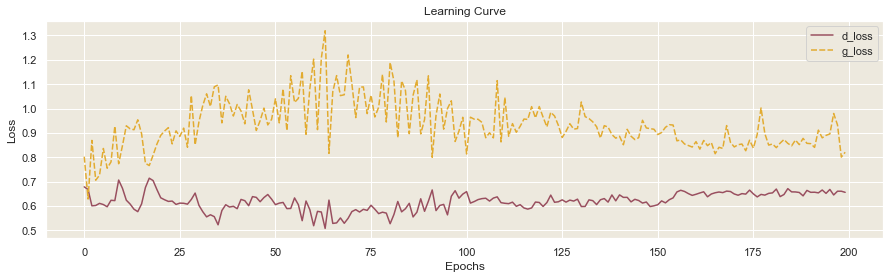

In [15]:
import pandas as pd
pal=["#994F5F","#E2AB30"]
#Plotting the learning curve
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

This looks good!

Let us get some portraits done by the GAN and appreciate the art created by this AI. To get the art output I will create a function that saves the output portraits generated. We will be plotting the generated Portraits

### Time to draw

In [21]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("./Portraits/Potraits{:02d}.png".format(i)) 
    return 

#Generating images
Images = Potrait_Generator()

Found 18 files belonging to 1 classes.


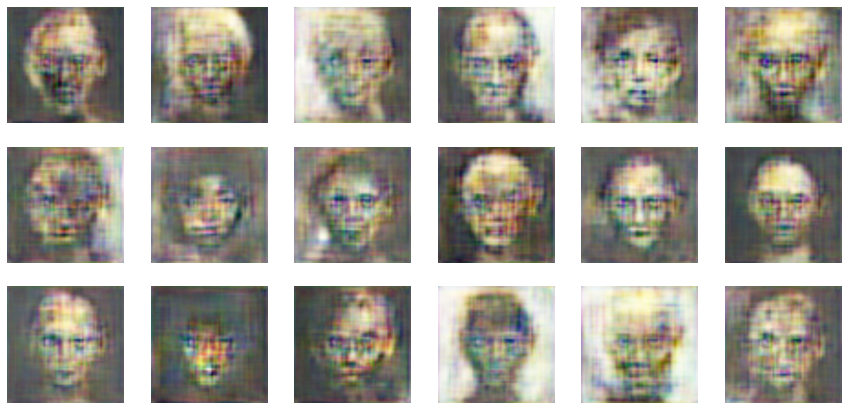

In [22]:
#Loading generated images
Generated_path = "./Portraits"
Potraits_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
#Plotting generated images
Show_Img(Potraits_generated)

The AI has done a great job, but since GANs are always data-hungry, I will need to add more data and even increase the number of epochs to make it generate more clear and good looking Potraits.